In [13]:
# Import Libraries
from cil.framework import AcquisitionGeometry, ImageGeometry
from cil.io import NEXUSDataWriter
from cil.processors import Slicer
from cil.utilities.display import show2D
from utils import download_zenodo

import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os

First, we download the Hyperspectral X-ray CT data set of mineralised ore sample with Au and Pb deposits from 
[Zenodo](https://zenodo.org/record/4157615#.YJEsQWYzZp8).

The data set consists of one .txt file and three .mat (MATLAB) data files.

1. `Au_rock_scan_geometry.txt` gives a breakdown of the full sample and detector geometry used when acquiring the raw projections. The number of horizontal detector pixels accounts for the fact that a set of 5 tiled scans of the sample were collected and later stitched together.

1. `Au_rock_sinogram_full.mat` contains the full 4D sinogram constructed following flat-field normalisation of the raw projection data. The data matrix contains the total number of energy channels acquired during scanning, as well as the conventional elements of vertical/horizontal detector pixel number and total projection angles.

1. `commonX.mat` provides a direct conversion between the energy channels, and the energies (in keV) that they correspond to, following a calibration procedure prior to scanning.

1. `FF.mat` contains the 4D flatfield data acquired when no sample was present. This data was used to normalise the projection datasets, as the sinogram was constructed.
 
**Note:** This will take some time.



In [2]:
download_zenodo()

In [3]:
pathname = os.path.abspath("MatlabData/")
# pathname = os.path.abspath("/home/edo/scratch/Dataset/CCPi/AuRock")
# spectral_data_sets/Au_rock/"
datafile = 'Au_rock_sinogram_full.mat'
ffdatafile = 'FF.mat'; # Flat fields
ecdatafile = 'commonX.mat'; # Energy channels (assumed center value and unit keV)

path1 = os.path.join(pathname, datafile)
path2 = os.path.join(pathname, ffdatafile) 
path3 = os.path.join(pathname, ecdatafile)

data_arrays1 = {}
data_arrays2 = {}

# Read Data
f1 = h5py.File(path1, 'r')
for k, v in f1.items():
    data_arrays1[k] = np.array(v)
    
# Read Flat fields    
f2 = h5py.File(path2,'r')
for k, v in f2.items():
    data_arrays2 = np.array(v)    
            
# Read Energy channels    
tmp_energy_channels = sio.loadmat(path3)        
echannels = tmp_energy_channels['commonX']

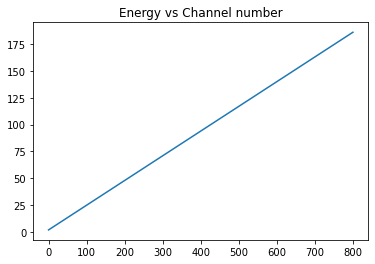

In [4]:
# Show Energy and Channel number relation
plt.figure()
plt.plot(echannels[0])
plt.title("Energy vs Channel number")
plt.show()

In [5]:
# Re-order shape of tmp_raw_data
tmp_raw_data = data_arrays1["S2"]
print("Sinogram Raw Data shape is [Channels, Horizontal, Angle, Vertical] = {}".format(tmp_raw_data.shape))
print("Need to re-order as (channel, vertical, angle, horizontal) ")

# re-order data as (channel, vertical, angle, horizontal)
tmp_raw_data = np.swapaxes(tmp_raw_data, 1, 3)
print("Re-order data shape is [Channels, Vertical, Angle, Horizontal] {}".format(tmp_raw_data.shape))
      
# # # flat field      
tmp_raw_flat = data_arrays2
print("Flat Fields shape is {}".format(tmp_raw_flat.shape))

Sinogram Raw Data shape is [Channels, Horizontal, Angle, Vertical] = (800, 400, 120, 80)
Need to re-order as (channel, vertical, angle, horizontal) 
Re-order data shape is [Channels, Vertical, Angle, Horizontal] (800, 80, 120, 400)
Flat Fields shape is (800, 400, 80)


In [6]:
# Flat field correction
# FF.mat contains the flat field at all energy channels, size 80x400x800.
# The 400 is horizontically stitched of 5 times 80 pixels, by moving detector.
# Something failed in the fifth position, so last 80 cannot be used.
# Position of the four others do not clearly seem to affect flat field, 
# so average these four and stitch together five copies of the average 
# to get flat field to use.

Fmean4 = 0.25*(tmp_raw_flat[:,0:80,:] + tmp_raw_flat[:,80:160,:] + tmp_raw_flat[:,160:240,:] + tmp_raw_flat[:,240:320,:])
Fmean = np.concatenate((Fmean4,Fmean4,Fmean4,Fmean4,Fmean4), axis=1)
Fmean = np.reshape(Fmean,[800,80,1,400]);

In [7]:
tmp = tmp_raw_data/Fmean
tmp800 = 0.*tmp
tmp800[tmp>0] = -np.log(tmp[tmp>0])

<ipython-input-7-83ac2edaabb6>:1: RuntimeWarning: divide by zero encountered in true_divide
  tmp = tmp_raw_data/Fmean
<ipython-input-7-83ac2edaabb6>:1: RuntimeWarning: invalid value encountered in true_divide
  tmp = tmp_raw_data/Fmean
<ipython-input-7-83ac2edaabb6>:2: RuntimeWarning: invalid value encountered in multiply
  tmp800 = 0.*tmp
<ipython-input-7-83ac2edaabb6>:3: RuntimeWarning: invalid value encountered in greater
  tmp800[tmp>0] = -np.log(tmp[tmp>0])


In [8]:
# Define AcquisitionGeometry and ImageGeometry
detector_pixel_size = 0.250 # mm
voxel_size = 0.065 # mm
source_to_sample_dist = 280.0 # mm
magnification_factor =  (detector_pixel_size/voxel_size) 

channels, vertical, num_angles, horizontal = tmp800.shape

print("Geometric magnification {}".format(magnification_factor))
print("Chanels {}".format(channels))
print("vertical {}".format(vertical))
print("num_angles {}".format(num_angles))
print("horizontal {}".format(horizontal))

# AcquisitionGeometry parameters
angles = np.linspace(-np.pi/4, 2*np.pi - np.pi/4, num_angles)
distanceSourceOrigin = source_to_sample_dist
distanceSourceDetector = magnification_factor*distanceSourceOrigin
distanceOriginDetector = distanceSourceDetector - distanceSourceOrigin

distanceSourceOrigin = distanceSourceOrigin/voxel_size
distanceOriginDetector = distanceOriginDetector/voxel_size

print("distanceSourceOrigin {}".format(distanceSourceOrigin))
print("distanceOriginDetector {}".format(distanceOriginDetector))

Geometric magnification 3.846153846153846
Chanels 800
vertical 80
num_angles 120
horizontal 400
distanceSourceOrigin 4307.692307692308
distanceOriginDetector 12260.355029585799


In [9]:
ag = AcquisitionGeometry.create_Cone3D(source_position = [0, -distanceSourceOrigin, 0],
                                       detector_position = [0, distanceOriginDetector, 0])\
                                    .set_panel([horizontal,vertical], [detector_pixel_size,detector_pixel_size])\
                                    .set_channels(channels)\
                                    .set_angles(-angles, angle_unit="radian")\
                                    .set_labels(['channel','vertical', 'angle', 'horizontal'])

In [10]:
raw_data = ag.allocate()
raw_data.fill(tmp800)

In [11]:
data = Slicer(roi={'channel': (318, 398)})(raw_data)

In [12]:
name = "full_raw_data_flat_field_318_398_channels.nxs"
writer = NEXUSDataWriter(file_name="HyperspectralData/"+name,
                         data = data)
writer.write()